# Problem Statement:
Many news aggregators face the challenge of common news stories published from many
providers. The importance of grouping based on similarity is very much important, so it can save
end users’ reading time. This is a more sort of clustering problem where similar articles should
be in the same group.

### IMPORT LIBRARIES

In [1]:
import pandas as pd
import re 

import nltk 
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics  import classification_report
from sklearn import metrics
import time

### LOAD DATASET

In [2]:
news_dataset=pd.read_csv("uci-news-aggregator.csv")

In [3]:
news_dataset

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027
...,...,...,...,...,...,...,...,...
422414,422933,Surgeons to remove 4-year-old's rib to rebuild...,http://www.cbs3springfield.com/story/26378648/...,WSHM-TV,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.cbs3springfield.com,1409229190251
422415,422934,Boy to have surgery on esophagus after battery...,http://www.wlwt.com/news/boy-to-have-surgery-o...,WLWT Cincinnati,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.wlwt.com,1409229190508
422416,422935,Child who swallowed battery to have reconstruc...,http://www.newsnet5.com/news/local-news/child-...,NewsNet5.com,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.newsnet5.com,1409229190771
422417,422936,Phoenix boy undergoes surgery to repair throat...,http://www.wfsb.com/story/26368078/phoenix-boy...,WFSB,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.wfsb.com,1409229191071


In [4]:
# Find all category
category = list(news_dataset['CATEGORY'].unique())
category

['b', 't', 'e', 'm']

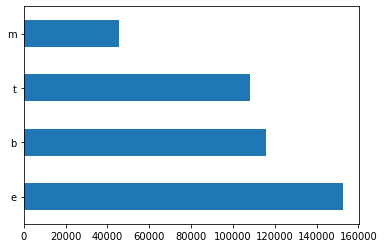

In [5]:
news_dataset['CATEGORY'].value_counts().plot(kind='barh')
plt.show()

In [6]:
# Check null values
news_dataset.isnull().sum()

ID           0
TITLE        0
URL          0
PUBLISHER    2
CATEGORY     0
STORY        0
HOSTNAME     0
TIMESTAMP    0
dtype: int64

### Text Preprocessing

In [7]:
# Text preprocessing
def preprocess(text):
    
    """
    Function: split text into words and return the root form of the words
    Args:
      text(str): the article
    Return:
      lem(list of str): a list of the root form of the article words
    """
        
    # Normalize text
    text = re.sub(r"[^a-zA-Z]", " ", str(text).lower())
    
    # Tokenize text
    token = word_tokenize(text)
    
    # Remove stop words
    stop = stopwords.words("english")
    words = [t for t in token if t not in stop]
    
    # Lemmatization
    lem = [WordNetLemmatizer().lemmatize(w) for w in words]
    
    return lem

In [8]:
news_dataset["Preprocessed_Title"] = news_dataset['TITLE'].apply(lambda x: preprocess(x))
news_dataset.head(10)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,Preprocessed_Title
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698,"[fed, official, say, weak, data, caused, weath..."
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207,"[fed, charles, plosser, see, high, bar, change..."
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550,"[u, open, stock, fall, fed, official, hint, ac..."
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793,"[fed, risk, falling, behind, curve, charles, p..."
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027,"[fed, plosser, nasty, weather, curbed, job, gr..."
5,6,Plosser: Fed May Have to Accelerate Tapering Pace,http://www.nasdaq.com/article/plosser-fed-may-...,NASDAQ,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.nasdaq.com,1394470372212,"[plosser, fed, may, accelerate, tapering, pace]"
6,7,Fed's Plosser: Taper pace may be too slow,http://www.marketwatch.com/story/feds-plosser-...,MarketWatch,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.marketwatch.com,1394470372405,"[fed, plosser, taper, pace, may, slow]"
7,8,Fed's Plosser expects US unemployment to fall ...,http://www.fxstreet.com/news/forex-news/articl...,FXstreet.com,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.fxstreet.com,1394470372615,"[fed, plosser, expects, u, unemployment, fall,..."
8,9,US jobs growth last month hit by weather:Fed P...,http://economictimes.indiatimes.com/news/inter...,Economic Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,economictimes.indiatimes.com,1394470372792,"[u, job, growth, last, month, hit, weather, fe..."
9,10,ECB unlikely to end sterilisation of SMP purch...,http://www.iii.co.uk/news-opinion/reuters/news...,Interactive Investor,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.iii.co.uk,1394470501265,"[ecb, unlikely, end, sterilisation, smp, purch..."


### Text Exploration

In [9]:
# Find the common words in each category
def find_common_words(df, category):
        
    """
    Function: find the most frequent words in the category and return the them
    Args:
      df(dataframe): the dataframe of articles
      category(str): the category name
    Return:
      the most frequant words in the category
    """
        
    # Create dataframes for the category
   # cat_df = df[df["category"]==category]
    
    # Initialize words list for the category
    words = [word for tokens in df["Preprocessed_Title"] for word in tokens]
    
    # Count words frequency
    words_counter = Counter(words)
 
    return words_counter.most_common(10)

In [10]:
print("Most common words in each category")
for c in category:
    print(c, " News")
    print(find_common_words(news_dataset, c))
    print()

Most common words in each category
b  News
[('new', 24461), ('u', 20453), ('google', 12545), ('say', 10944), ('apple', 10473), ('video', 10155), ('star', 8549), ('first', 8446), ('report', 8331), ('samsung', 8284)]

t  News
[('new', 24461), ('u', 20453), ('google', 12545), ('say', 10944), ('apple', 10473), ('video', 10155), ('star', 8549), ('first', 8446), ('report', 8331), ('samsung', 8284)]

e  News
[('new', 24461), ('u', 20453), ('google', 12545), ('say', 10944), ('apple', 10473), ('video', 10155), ('star', 8549), ('first', 8446), ('report', 8331), ('samsung', 8284)]

m  News
[('new', 24461), ('u', 20453), ('google', 12545), ('say', 10944), ('apple', 10473), ('video', 10155), ('star', 8549), ('first', 8446), ('report', 8331), ('samsung', 8284)]



In [11]:
news_dataset['Preprocessed_Title1'] = news_dataset['Preprocessed_Title'].apply(' '.join)
news_dataset.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,Preprocessed_Title,Preprocessed_Title1
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698,"[fed, official, say, weak, data, caused, weath...",fed official say weak data caused weather slow...
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207,"[fed, charles, plosser, see, high, bar, change...",fed charles plosser see high bar change pace t...
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550,"[u, open, stock, fall, fed, official, hint, ac...",u open stock fall fed official hint accelerate...
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793,"[fed, risk, falling, behind, curve, charles, p...",fed risk falling behind curve charles plosser say
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027,"[fed, plosser, nasty, weather, curbed, job, gr...",fed plosser nasty weather curbed job growth


In [12]:
# Determine data and target
X = news_dataset['Preprocessed_Title1']
y = news_dataset['CATEGORY']

### Feature Extraction¶
 #### use TF-IDF method to extract the text features.

In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [14]:
# Use TF-IDF
tf_vec = TfidfVectorizer()
train_features = tf_vec.fit(X_train)
train_features = tf_vec.transform(X_train)
test_features = tf_vec.transform(X_test)

### Modeling
#### Use the below machine learning algorithms then I will select the best one based on its training time, accuracy score and f-beta scores.

#### *Decision Tree
#### *Multinomial Naive Bayes

In [15]:
# Train and evaluate model
def fit_eval_model(model, train_features, y_train, test_features, y_test):
    
    """
    Function: train and evaluate a machine learning classifier.
    Args:
      model: machine learning classifier
      train_features: train data extracted features
      y_train: train data lables
      test_features: train data extracted features
      y_test: train data lables
    Return:
      results(dictionary): a dictionary of the model training time and classification report
    """
    results ={}
    
    # Start time
    start = time.time()
    # Train the model
    model.fit(train_features, y_train)
    # End time
    end = time.time()
    # Calculate the training time
    results['train_time'] = end - start
    
    # Test the model
    train_predicted = model.predict(train_features)
    test_predicted = model.predict(test_features)
    
     # Classification report
    results['classification_report'] = classification_report(y_test, test_predicted)
        
    return results

In [16]:
# Initialize the models
tree = DecisionTreeClassifier()
nb = MultinomialNB()


# Fit and evaluate models
results = {}
for cls in [tree,nb]:
    cls_name = cls.__class__.__name__
    results[cls_name] = {}
    results[cls_name] = fit_eval_model(cls, train_features, y_train, test_features, y_test)

In [17]:
# Print classifiers results
for res in results:
    print (res)
    print()
    for i in results[res]:
        print (i, ':')
        print(results[res][i])
        print()
    print ('-----')
    print()

DecisionTreeClassifier

train_time :
213.74901413917542

classification_report :
              precision    recall  f1-score   support

           b       0.88      0.90      0.89     23258
           e       0.94      0.95      0.95     30328
           m       0.90      0.87      0.88      9239
           t       0.91      0.89      0.90     21659

    accuracy                           0.91     84484
   macro avg       0.91      0.90      0.90     84484
weighted avg       0.91      0.91      0.91     84484


-----

MultinomialNB

train_time :
1.3894076347351074

classification_report :
              precision    recall  f1-score   support

           b       0.90      0.91      0.90     23258
           e       0.95      0.97      0.96     30328
           m       0.96      0.86      0.91      9239
           t       0.90      0.90      0.90     21659

    accuracy                           0.92     84484
   macro avg       0.93      0.91      0.92     84484
weighted avg       0.92 

### Note: From the testing results, we can see that MultinomialNB classifier is the fastest and most accurate classifier.

## Use the Model

### Now,  use the built MultinomialNB model to classify new articles.

In [20]:
# Classify an article
def classify_article(path):
    
    """
    Function: classify an article.
    Args:
      path: the path of the article 
    Return:
      category (str): the category of the article
    """
    # Read file
    file = open(path, 'r',encoding='utf-8')
    artcl = file.read()

    # Text preprocessing
    artcl = preprocess(artcl)
    artcl = ' '.join(artcl)

    # Use TF_IDF
    test = tf_vec.transform([artcl])

    # Use MultinomialNB model to classify the article
    predict = nb.predict(test)
    category = predict[0]

    # Close file
    file.close()

    return category

In [21]:
print(classify_article('art1.txt'))

b


In [22]:
print(classify_article('art2.txt'))

b


In [23]:
print(classify_article('art3.txt'))

b


In [24]:
print(classify_article('art4.txt'))

e


## Summary

#### In this project,  used Kaggal  news dataset to classify the news topics. I used TF-IDF feature extraction algorithm and  different
#### machine learning algorithms:  Decision Tree, Multinomial Naive Bayes. Multinomial Naive Bayes was the best model and then I  
#### use it to classify new articles in order to check the model accuracy.